In [1]:
# Import some basic packages
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import warnings

# **Coupling Landlab components to simulate a floodplain response**
```
NetworkSedimentTransporter | OverlandFlow | SoilInfiltrationGreenAmpt
```

## Graphical abstract? 

<img src="https://i.imgur.com/jS8EqiI.jpg" alt="conceptual framework" width="500"/>

get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings('ignore')
import os
import shutil
import pathlib
from landlab.components import OverlandFlow, FlowAccumulator, SpatialPrecipitationDistribution, FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.components import SoilInfiltrationGreenAmpt
from landlab import RasterModelGrid
from landlab import ExampleData
from landlab.plot import plot_network_and_parcels

## 1. Drainage network topology

### 1.1 Import network from a shapefile

We start by loading a shapefile containing the topology of the drainage network as a Landlab grid which will be stored as `network_grid`. This network is composed of nodes and links, meaning it will work as a one-dimensional grid. 

In [2]:
# Package for reading shapefiles
from landlab.io import read_shapefile

# Read shapefile as Landlab grid
PATH_TO_SHAPEFILE = './data/hugo_links.shp'
network_grid = read_shapefile(PATH_TO_SHAPEFILE,threshold=0.1,)

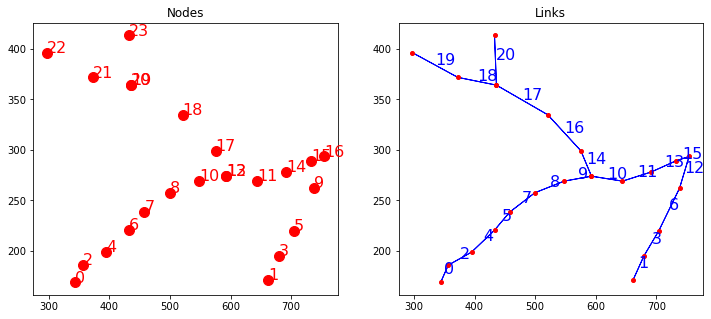

In [3]:
# Package for plotting networks
from landlab.plot import graph

## Plot nodes
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
graph.plot_nodes(network_grid)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(network_grid,with_id=False,markersize=4)
graph.plot_links(network_grid)
plt.title("Links")
plt.show()

### 1.2 Fix network and create a new one

Notice how `network_grid` is not *really* a network. For example, lines <font color='blue'>18</font> and <font color='blue'>20</font> should arrive to the same node, however, there are two nodes at the same location. After inspecting the plot, it seems that nodes <font color='red'>19</font> and <font color='blue'>13</font> can be deleted since nodes <font color='blue'>20</font> and <font color='blue'>12</font> are in the same place.

In [4]:
# Drop double nodes
drop_nodes = [19,13]
new_y_of_node =[]
new_x_of_node =[]

# Find the new x and y coordinates
for i, node in enumerate(network_grid.y_of_node):
    if i not in drop_nodes:
        new_y_of_node.append(node)

for i, node in enumerate(network_grid.x_of_node):
    if i not in drop_nodes:
        new_x_of_node.append(node)

The lines that arrived to those deleted points have to be rebuilt so they get to the nodes that we kept.

In [5]:
# Redirect all nodes
replace_nodes = [20,12]
nodes_reformatted=np.ravel(network_grid.nodes_at_link)

for node, replacement in zip(drop_nodes,replace_nodes):
    nodes_reformatted[np.where(nodes_reformatted==node)]=replacement

# Change index number     
for node in drop_nodes:
    nodes_reformatted[np.where(nodes_reformatted >node)] -=1
    
new_nodes_at_link=nodes_reformatted.reshape([21,2])

For this, a new grid is created, called `new_network_grid`.

In [6]:
# Package for building a new network
from landlab.grid.network import NetworkModelGrid 
new_network_grid = NetworkModelGrid((new_y_of_node, new_x_of_node), new_nodes_at_link)
#                                   ^                            ^ ^                ^
#                                   ^--------Node Coordinates----^ ^----Links id----^

Now the links in `new_network_grid` indeed form a network! 

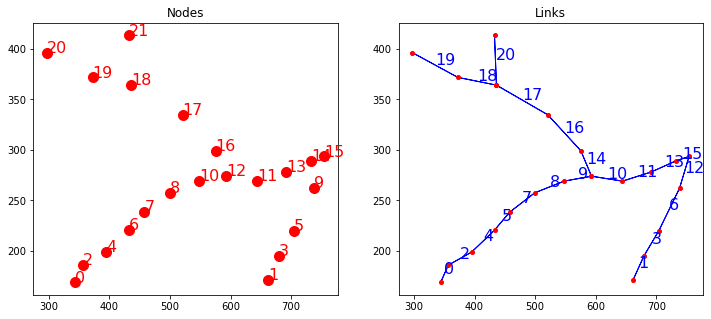

In [7]:
# Plot network topology
# Plot network topology
## Plot nodes
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
graph.plot_nodes(new_network_grid)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(network_grid,with_id=False,markersize=4)
graph.plot_links(new_network_grid)
plt.title("Links")
plt.show()

***
## 2. Rainfall and runoff on a topography

### 2.1 Import topography from a raster

Just as before, a raster file containing the topography of an area is loaded 
as a Landlab grid which will be stored as `rmg`. In this case, we will be dealing with a two-dimensional grid composed of the tiles that make up the raster file. 

The elevation attribute read from this raster is stored as `z`, which is connected to the fixed name `'topographic__elevation'`.

In [8]:
# Package for reading raster files
from landlab.io.esri_ascii import read_esri_ascii, write_esri_ascii

# Read raster as Landlab grid and assign info in raster as z.
PATH_TO_TOPOGRAPHY = './data/hugo_site.asc'
rmg, z = read_esri_ascii(PATH_TO_TOPOGRAPHY, name='topographic__elevation')

In [9]:
# Nodes with an elevation of -9999 are considered empty => interpreted as closed boundaries in the system
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED
rmg.set_watershed_boundary_condition('topographic__elevation')

Let's check the topography of this basin. Notice that we plot the `'topographic__elevation'` of the grid `rmg`, rather than plotting the `z` variable that we stored before. However, `z` points to `'topographic__elevation'`. 

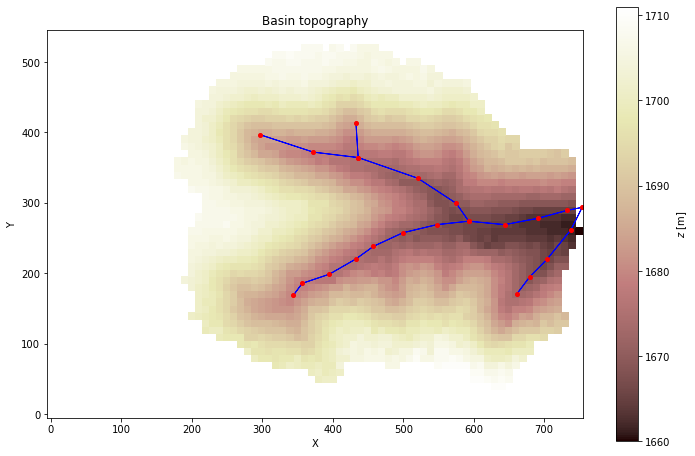

In [10]:
# Package for plotting raster data
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node

# Plot topography
plt.figure(figsize=(12,8))
graph.plot_nodes(network_grid,with_id=False,markersize=4)
graph.plot_links(new_network_grid,with_id=False)
imshow_grid(rmg, 'topographic__elevation',\
            plot_name="Basin topography",\
            color_for_closed=None,\
            colorbar_label="$z$ [m]")
plt.show()

### 2.2 Add a storm

Rain is added as a layer of water on top of the topography imported before. For the overland flow model, this is done by adding information to the `surface_water__depth` attribute of the grid `rmg` we are working on. 

First, we can add a homogeneous rain falling over the whole domain just by populating `surface_water__depth` with a constant value `h_init`.

In [11]:
# Initial thin layer of water (m)
h_init = 0.05 

# Start with a dry terrain
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)

h = rmg.at_node['surface_water__depth']  # h >> surface water depth
h += h_init                              #add a little bit of water everywhere

Similarly, a spatially variable rain pattern can be added modifying the array `h`. In this case, we add some more rain in a rectagular region. 

In [12]:
# Create a list of indexes where to add the rain
bools = (rmg.node_y > 100)*(rmg.node_y < 450)*(rmg.node_x < 400)*(rmg.node_x > 200)

# Add the rain only to the indexes defined above
h[bools] = 0.15 #initial water depth m

Let's check how this rain is distributed on the basin by plotting `h` with the `imshow_grid` function. 

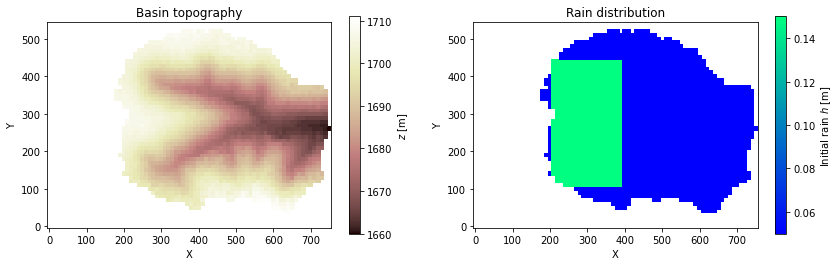

In [13]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
imshow_grid(rmg, 'topographic__elevation',\
            plot_name="Basin topography",\
            color_for_closed=None,\
            colorbar_label="$z$ [m]",\
            output=None,shrink=0.5)
plt.subplot(1,2,2)
imshow_grid(rmg, h,\
            plot_name="Rain distribution",\
            color_for_closed=None,\
            colorbar_label="Initial rain $h$ [m]",\
            cmap="winter",output=None,shrink=0.5)
plt.show()

### 2.3 Calculate the discharge

The rain field will act as the initial condition for the Overland Flow model to calculate the discharge in the basin. We start by initializing the `surface_water__discharge` attribute in `rmg`.

In [14]:
## Set inital discharge to zero
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

***
## 3. Sediment transport

****************************
I'm here :B

In [ ]:
# Initial conditions
run_time =50000# 1 day 259200  # duration of run, (s) equivalent of 3 days
n = 0.01  # roughness coefficient, (s/m^(1/3))
g = 9.8  # gravity (m/s^2)
alpha = 0.7  # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4  # constant velocity (m/s, de Almeida et al., 2012)
elapsed_time = 1.0 #Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.

In [ ]:
nmg_node_topo = np.zeros(new_grid.number_of_nodes) #create empty array holding elevations for network model grid
nmg_node_h = np.zeros(new_grid.number_of_nodes)

for i in range(new_grid.number_of_nodes):
    idx_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[i], new_grid.y_of_node[i]])
    nmg_node_topo[i] = rmg.at_node["topographic__elevation"][idx_nearest_raster_cell]

nmg_link_length = np.zeros(new_grid.number_of_links)
nmg_link_h = np.zeros(new_grid.number_of_links)

In [ ]:
for i in range(new_grid.number_of_links):
    idx_node_1_link = new_grid.nodes_at_link[i][0]
    idx_node_2_link = new_grid.nodes_at_link[i][1]
    nmg_link_length[i] = np.sqrt((new_grid.x_of_node[idx_node_2_link] - new_grid.x_of_node[idx_node_1_link])**2 
                         + (new_grid.y_of_node[idx_node_2_link] - new_grid.y_of_node[idx_node_1_link])**2)
    square_idx = rmg.find_nearest_node([new_grid.x_of_node[idx_node_1_link], new_grid.y_of_node[idx_node_1_link]]) #get raster grid idx closest to link tail
    nmg_link_h[i] = rmg.at_node['surface_water__depth'][square_idx] #assign surface at square_idx to network grid

new_grid.at_node["topographic__elevation"] = nmg_node_topo.copy()

new_grid.at_node["bedrock__elevation"] = nmg_node_topo.copy()

new_grid.at_link["channel_width"] = 10 * np.ones(grid.number_of_links)

new_grid.at_link["flow_depth"] = nmg_link_h.copy()

new_grid.at_link["reach_length"] = nmg_link_length

In [ ]:
# Folder for rainfall data
dir_rainfall = './rainfall_series'
# Overwrite or create directory for rainfall data
if os.path.exists(dir_rainfall):
    shutil.rmtree(dir_rainfall)
os.makedirs(dir_rainfall)

# time scale for rainfall events. To be adjusted. I am cheating with units... 
nb_years = 100
# Factor to scale rainfall values from the module SpatialPrecipitationDistribution (may generate very
# small amounts of rainfall, which renders poorly...)
rainfall_scaling = 10.

# Create time series of rainfall events (output is in mm/h)
rain = SpatialPrecipitationDistribution(rmg,number_of_years = nb_years)
np.random.seed(26)  # arbitrary to get a cool-looking storm out every tim

# Container for rainfall duration
storm_t_all = []
interstorm_t_all = []

# get the storm simulator to provide a storm
# Variables required to generate rainfall datasets
i = 0
max_rainfall = []
for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
    i += 1
    rmg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    rmg.at_node['rainfall__flux'] *= rainfall_scaling  # to make the storm heavier and more interesting!

    # Save rainfall data to ascii file
    write_esri_ascii('./'+ dir_rainfall +'/rainfall_'+ str(i) + '.asc', rmg, 'rainfall__flux', clobber=True)
    
    # Save duration of storm and non-storm periods
    storm_t_all.append(storm_t)
    interstorm_t_all.append(interstorm_t)
    
    # Store max rainfall value
    max_rainfall.append(max(rmg.at_node['rainfall__flux']))

storm_ids = np.array(range(len(storm_t_all))) + 1

# Get moment of storms (initially in hours, to be rescaled over run_time 
# -> cheating to get some results...)
days_storms = (np.array(interstorm_t_all)/24)
scaled_days_storms_steps = (days_storms * (run_time / (nb_years*365))).round()
scaled_days_storms = scaled_days_storms_steps.cumsum()
# Set first storm a time = 1
scaled_days_storms = scaled_days_storms - scaled_days_storms[0] + 1

#Set initial water depth values and rainfall flux values
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
rmg.at_node.pop('rainfall__flux')
# print(rmg.at_node.keys())

# Read first rainfall data
q_rain = read_esri_ascii(dir_rainfall + '/rainfall_1.asc', grid=rmg, name='rainfall__flux')
# Update id for rainfall
rainfall_id = 1

# Update surface water depth with rainfall data
rmg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
rmg.at_node['surface_water__depth'] += rmg.at_node['rainfall__flux'] # storm_t_all[0]

## Set inital discharge
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)



In [ ]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(new_grid.number_of_links), 50)
element_id = np.expand_dims(element_id, axis=1)

volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.002 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In [ ]:
lithology = ["quartzite"] * np.size(element_id)

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}


items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    new_grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

dt_sed = 100 # 60 * 60 * 24 *1# length of timestep (seconds) 

In [ ]:
# set up overland flow grid for small-scale floodplain

Channel_Width = 8.
Channel_Depth = 2.

nX = 200
nY = 100
spacing = 1.0
Datum = 1665.0 + Channel_Depth
h_initFP = 0.1


def makeFP(Channel_Depth, Channel_Width = 8):
    
    #Define grid
    nX = 200
    nY = 100
    spacing = 1.0
    Datum = 1665.0 + Channel_Depth
    h_initFP = 0.1

    _grd = RasterModelGrid((nX, nY), xy_spacing=1.)

    # Pointer to topographic elevation > z
    _z = np.ones(nX*nY) * Datum
    _z = _grd.add_field('topographic__elevation', _z, at='node')

    # Add a longitudinal slope 
    ## (makes thing flow north to south)
    Long_Slope = 1./1000
    _z += _grd.node_y*Long_Slope

    # Add the channel indentation 
    ## (it's just a straigth strip)
    
    isChannel = (_grd.node_x > (nY/2 - Channel_Width/2)) * (_grd.node_x < (nY/2 + Channel_Width/2))
    _z[isChannel] -= Channel_Depth

    # Add a slope to the banks
    ## (so water flows always towards the main channel)
    Transversal_Slope = 1./100
    _z += np.abs(_grd.node_x-(nY/2))*Transversal_Slope

    # Add some random noise to the floodplains
    ## (makes the hillshading look prettier)
    _z += ~isChannel * np.reshape(np.tile(np.random.rand(10,10)*0.20,[int(nX/10),int(nY/10)]),nX*nY) 
    
    return _grd, _z, isChannel


In [ ]:
gridFP, zFP, isChannel = makeFP(Channel_Depth = 2)

In [ ]:
# Pointer to surface water depth in the 2D floodplain
hFP = np.zeros(nX*nY)
bools = (gridFP.node_x > nY/2 - Channel_Width*3) * (gridFP.node_x < nY/2 + Channel_Width*2) * (gridFP.node_y >= nX-5)
hFP[bools] = Channel_Depth*0.5
hFP += h_initFP
hFP = gridFP.add_field('surface_water__depth', hFP, at='node')

#####################################
# Spatially variable hydraulic cond. 
#####################################

dFP = gridFP.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
dFP *= 0.2

hcFP = gridFP.add_ones('hydraulic_conductivity', at='node')
hcFP *= 1.0E-5

infBandWidthNorm = 0.3
infBandWidth = nY/2 * infBandWidthNorm

channel_left = (nY + Channel_Width) / 2
channel_right = (nY - Channel_Width) / 2

#Define high infiltration bands at the banks

highInfBand = np.logical_and(gridFP.x_of_node < channel_left + infBandWidth, 
                             gridFP.x_of_node > channel_right - infBandWidth)
inf_maskFP = np.logical_xor(highInfBand, isChannel)

hcFP[inf_maskFP] *= 10

In [ ]:
# Initialize model components

# overland flow in the floodplain
floodplainOF = OverlandFlow(gridFP, steep_slopes=True)

# soil infiltration in the floodplain
SI = SoilInfiltrationGreenAmpt(gridFP, hydraulic_conductivity=hcFP)

# Flow direction in channel network
fd = FlowDirectorSteepest(new_grid, "topographic__elevation")
fd.run_one_step()

#network sed transporter 
nst = NetworkSedimentTransporter(    
    new_grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

# overland flow in the channel network
networkOF = OverlandFlow(rmg, steep_slopes=True)
networkOF.run_one_step()

In [ ]:
# look at hydrograph at outlet 
hydrograph_time = []
discharge_at_outlet = []
height_at_outlet = []

#Define the outlet 
outlet_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[14], new_grid.y_of_node[14]]) 
# did not choose 15 since at boundary
outlet_link_to_sample = rmg.links_at_node[outlet_nearest_raster_cell][3]

In [ ]:
# Plot 2D domain topography
fig = plt.figure(figsize=(10,8))
ls = LightSource(azdeg=315, altdeg=45)
plt.imshow(ls.hillshade(np.reshape(zFP,[nX,nY]), vert_exag=10), cmap='gray')
plt.show()

# # Plot 2D domain hydraulic cond.
# fig = plt.figure(figsize=(10,8))
# # plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
# imshow_grid(grid,'hydraulic_conductivity')
# plt.title("Hydraulic Conductivity")
# fig.show()

# print(new_grid.at_node['topographic__elevation'][14])
# print(zFP)
# print(rmg.at_node.keys())

# cll = rmg.find_nearest_node([new_grid.x_of_node[14], new_grid.y_of_node[14]]) 

# print(cll)
# rmg.at_node['surface_water__discharge'][cll]

In [ ]:
# driving the model forward in a loop
elapsed_time = 1.
run_time = 5000
iters = 0

old_channel_depth = Channel_Depth

bools = (gridFP.node_x > nY/2 - Channel_Width*3) * (gridFP.node_x < nY/2 + Channel_Width*2) * (gridFP.node_y >= nX-5)

# #Figure outputs
# mydpi = 96
# sizeFigure = 400
# system("rm -r ResultImages/*.png")

rainfall_id = 0

dt_sed = 100

run_time_slices = np.arange(500,run_time+1,dt_sed)

for t in run_time_slices:
    
    elapsed_time_FP = float(elapsed_time)
    
    while elapsed_time < t:
    
        # make rain

        if int(elapsed_time) in scaled_days_storms:
            # print("STORMMMM")
            # Update rainfall dataset id
            rainfall_id += 1
            rainfall_name = 'rainfall__flux_' + str(rainfall_id)
            # print(rainfall_id)

            # Avoid last time step
            if rainfall_id <= len(scaled_days_storms):
                # Read rainfall data
                # rmg.at_node.pop('rainfall__flux')
                read_esri_ascii('./rainfall_series/rainfall_' + str(rainfall_id) + '.asc', 
                                grid=rmg, name=rainfall_name)
                # Add rainfall event to water depth
                rmg.at_node['surface_water__depth'] += rmg.at_node[rainfall_name]
                print(np.sum(rmg.at_node[rainfall_name]))
    
        # route overland flow

        # First, we calculate our time step.
        dt_overland = 1 #networkOF.calc_time_step()
        #print('overland flow timestep is',dt_overland,'seconds')
        # Now, we can generate overland flow.
        networkOF.overland_flow()
        # Increased elapsed time
        elapsed_time += dt_overland
        #print("Model time: ",elapsed_time/(60*60*24), "days passed")
        ## Append time and discharge and water depth to their lists to save data and for plotting.
        hydrograph_time.append(elapsed_time) 
        q_output = rmg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q_output[outlet_link_to_sample]) * rmg.dx)
        h_output = rmg.at_node['surface_water__depth']
        height_at_outlet.append(np.abs(h_output[outlet_nearest_raster_cell]))
#         print(elapsed_time)

    # route sediment

    # updated the water depth in network graph
    for i in range(new_grid.number_of_links):
        idx_node_1_link = new_grid.nodes_at_link[i][0]
        idx_nearest_raster_cell = rmg.find_nearest_node([
            new_grid.x_of_node[idx_node_1_link], 
            new_grid.y_of_node[idx_node_1_link]])
        nmg_link_h[i] = rmg.at_node['surface_water__depth'][idx_nearest_raster_cell ] 
    new_grid.at_link["flow_depth"] = nmg_link_h.copy()
    
#     print(new_grid.at_link["flow_depth"])
    
    nst.run_one_step(dt_sed)
    
  #Plot overland flow 
    fig=plt.figure(1)
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()
    
    # change the floodplain
    
    new_channel_depth = Datum - new_grid.at_node['topographic__elevation'][14]
    
    zFP[isChannel] += new_channel_depth - old_channel_depth
    
    old_channel_depth = new_channel_depth
    
#     set the boundary condition at the upstream end to be 

    new_grid.at_node['topographic__elevation'][14]
    
    j = 0
    
    while elapsed_time_FP < t:
        hFP[bools] = height_at_outlet[j]
        # First, we calculate our time step.
        dt_overland = 1 # floodplainOF.calc_time_step()
        #print('overland flow timestep is',dt_overland,'seconds')
        # Now, we can generate overland flow.
        floodplainOF.overland_flow()
        # now, allow water to infiltrate
        SI.run_one_step(dt_overland)
        # Increased elapsed time
        elapsed_time_FP += dt_overland
        j += 1
#         print(elapsed_time_FP)
  
    #Plot overland flow 
    fig=plt.figure(2)
    imshow_grid(gridFP,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(gridFP,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
#     plt.plot(gridFP.node_x[outlet_nearest_raster_cell], gridFP.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()
    

In [ ]:
# Plotting hydrographs and discharge
fig=plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "b-", label="outlet")
plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(f"runoff_discharge.jpeg")
fig=plt.figure(3)
plt.plot(hydrograph_time, height_at_outlet, "b-", label="outlet")
plt.ylabel("Water depth (m)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig("runoff_waterdepth.jpeg")
## Plotting sediment volume
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0
sum_parcel_vol_on_grid = np.sum(parcel_vol_on_grid, axis=0)
fig=plt.figure(4)
plt.plot(np.asarray(parcels.time_coordinates), 
         sum_parcel_vol_on_grid[0]-sum_parcel_vol_on_grid,'b-',label="outlet"
        )
plt.ylim(4, 500)
plt.ylabel('Total volume of parcels that left catchment $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 
  

In [ ]:
    #Plot overland flow 
    fig=plt.figure()
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()

    #grain size
    parcel_D = parcels.dataset.D.values.copy()
    parcel_D_off_grid=parcel_D[parcels.dataset["element_id"].values==-2] 

    # the histogram of the data
    plt.hist(parcel_D_off_grid*1000, histtype='bar')
    plt.xlabel('grain size (mm)')
    plt.ylabel('Count')
    plt.title('Histogram of grain sizes that left grid')
    plt.text(0.011, 700, r'original distribution $\mu=2 mm$')
    plt.xlim(0, 20)
    plt.ylim(0, 4000)
    plt.grid(True)
    plt.show()
    
    print(np.abs(h[outlet_nearest_raster_cell]))
    print(new_grid.at_node['bedrock__elevation'][14] )
    print(new_grid.at_node['topographic__elevation'][14] )
    # change floodplain
    
    #Plot sediment parcels locations
 #   fig = plot_network_and_parcels(
 #           new_grid, parcels, 
 #           parcel_time_index=len(parcels.time_coordinates)-1)
#    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
#    plt.title(f'Time = {round(elapsed_time,1)} s')
#    plt.show()
    
#     # route floodwater on floodplain
    
#     # First, we calculate our time step.
#     dt = of.calc_time_step()
#     # Now, we can generate overland flow.
#     of.overland_flow()
#     SI.run_one_step(dt)
    
#     if iters %50==0:
#         print('Elapsed time: ', elapsed_time)
#         fig = plt.figure(figsize=(sizeFigure/mydpi, sizeFigure/mydpi), dpi=mydpi)
#         plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
#         imshow_grid(grid,'surface_water__depth',
#         limits=(0,1),cmap=WaterMap,                    
#         colorbar_label="Water depth (m)",                    
#         plot_name="Time = %i" %elapsed_time)
#         fig.savefig("ResultImages/" + str(iters).zfill(5) + ".png")
    
#     elapsed_time += dt
#     iters += 1

In [ ]:
print(new_grid.at_node.keys())
print(new_grid.at_node['topographic__elevation'])

In [ ]:

# Plotting hydrographs and discharge
fig=plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "b-", label="outlet")

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(f"runoff_discharge.jpeg")

fig=plt.figure(3)
plt.plot(hydrograph_time, height_at_outlet, "b-", label="outlet")
plt.ylabel("Water depth (m)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig("runoff_waterdepth.jpeg")


## Plotting sediment volume
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0

sum_parcel_vol_on_grid = np.sum(parcel_vol_on_grid, axis=0)

plt.figure(figsize=(8,6))
plt.plot(np.asarray(parcels.time_coordinates)/(60*60*24), 
         sum_parcel_vol_on_grid[0]-sum_parcel_vol_on_grid,
         '-',
         linewidth=3, 
        )
plt.ylabel('Total volume of parcels that left catchment $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 


In [ ]:
# land flow 
    fig=plt.figure()
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()
#     fig.savefig(

In [ ]:
new_grid

In [ ]:
parcels.time_coordinates

In [ ]:
fig = plot_network_and_parcels(
    new_grid, parcels, 
    parcel_time_index=0)
plt.title(f'Time = {round(elapsed_time,1)} s')
plt.show()
    

In [ ]:
# # plotting model results

# images=[]
# original_files=list(glob("./ResultImages/*.png"))
# original_files.sort(reverse=False)
# for file_ in original_files:
#     images.append(imageio.imread(file_))
# imageio.mimsave('./animation.gif', images, duration=1/5, subrectangles=True)



In [ ]:

# # Check the 2D domain topography
# fig = plt.figure(figsize=(10,8))

# ## Cross Section
# ax1 = plt.subplot(2,1,1)
# ax1.plot(grid.node_x[grid.node_y==nX/2],z[grid.node_y==nX/2],label="Cross Section")
# ax1.set_ylabel("Elevation (??)")
# ax1.set_xlabel("Distance X (??)")
# ax1.legend()

# ## Long Section
# ax2 = plt.subplot(2,1,2)
# ax2.plot(grid.node_y[grid.node_x==nY/2],z[grid.node_x==nY/2],label="Longitudinal Section")
# ax2.set_ylabel("Elevation (??)")
# ax2.set_xlabel("Distance Y (??)")
# ax2.legend()

# fig.show()